In [ ]:
# ==============================================================================
# 📚 1. Standard Library Imports
# ==============================================================================
from datetime import date, datetime
import sys
from typing import List, Set, Tuple

# ==============================================================================
# 📚 2. Third-Party Library Imports
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display

# ==============================================================================
# 📚 3. Helper Module Imports
# ==============================================================================
# Assuming these exist in your local environment
from input_number_symbols import get_integer_input, get_valid_symbols
from date_checker import get_min_valid_date, get_valid_date_input
from interval import set_interval

# ==============================================================================
# ⚙️ 4. Global Constants (Risk-Free Rate)
# ==============================================================================
# Using 4.25% Annual Risk-Free Rate as a default proxy
RISK_FREE_RATE_ANNUAL = 4.25


# ==============================================================================
# ⬇️ 5. Optimized Rolling Metric Function
# ==============================================================================


def calculate_rolling_metrics_optimized(
    df: pd.DataFrame, time_frame: int, time_step: int, coefficient: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calculates rolling Mean, Volatility, and Sharpe Ratio.
    """
    if time_frame > len(df):
        raise ValueError("Time frame is larger than the total number of data points.")

    # Calculate simple returns
    df_simple_returns = df.pct_change() * 100
    df_simple_returns = df_simple_returns.dropna()

    # 1. Calculate Rolling Mean & Volatility
    df_rolling_mean = df_simple_returns.rolling(window=time_frame).mean()
    df_rolling_vol = df_simple_returns.rolling(window=time_frame).std()

    # 2. Calculate Rolling Sharpe Ratio
    # Formula: (Rolling Mean - Daily Risk Free) / Rolling Volatility
    Rf_per_period = (1 + RISK_FREE_RATE_ANNUAL) ** (1 / coefficient) - 1
    df_rolling_sharpe = (
        (df_rolling_mean - Rf_per_period) / df_rolling_vol * np.sqrt(coefficient)
    )

    # 3. Step the results to reduce data density for plotting
    start_index = time_frame - 1
    df_mean_stepped = df_rolling_mean.iloc[start_index::time_step].dropna(how="all")
    df_vol_stepped = df_rolling_vol.iloc[start_index::time_step].dropna(how="all")
    df_sharpe_stepped = df_rolling_sharpe.iloc[start_index::time_step].dropna(how="all")

    return (df_mean_stepped, df_vol_stepped, df_sharpe_stepped)


# ==============================================================================
# 📈 6. Visualization Function
# ==============================================================================


def plot_metrics(
    df: pd.DataFrame,
    title: str,
    is_rolling: bool,
    kind: str = "line",
    time_frame: int = None,
    time_step: int = None,
    value_label: str = None,
):
    """Generates and displays a plot (Line or Bar) for the given DataFrame."""
    try:
        # Create figure
        plt.figure(figsize=(12, 6))

        full_title = title
        x_label = "Date"

        if is_rolling:
            full_title += f"\n(Window Size: {time_frame}, Step: {time_step})"
            x_label = "End Date of Rolling Window"

        # Plot Logic
        if kind == "bar":
            # Bar chart for scalar comparisons (Full Period)
            # We use a distinct color (e.g., orange) for volatility if indicated in title, otherwise default
            if "Volatility" in title:
                color = "red"
            elif "Sharpe" in title:
                color = "blue"

            df.plot(
                kind="bar", figsize=(12, 6), color=color, alpha=0.8, edgecolor="black"
            )
            plt.axhline(0, color="black", linewidth=0.8)  # Add zero line
            x_label = "Symbols"
            plt.xticks(rotation=0)
        else:
            # Line chart for time series (Rolling)
            plt.plot(df)
            x_label = "Date"
        if value_label:
            y_label = value_label
        else:
            y_label = "Value"

        plt.title(full_title, fontsize=16)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label, fontsize=12)

        if kind == "line":
            plt.legend(
                df.columns, title="Symbols", bbox_to_anchor=(1.05, 1), loc="upper left"
            )
        else:
            # For bar charts, the legend is often redundant if the x-axis labels are clear,
            # but we keep it for consistency or disable if single metric.
            pass

        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not generate plot for '{title}'. Error: {e}")


# ==============================================================================
# 🏁 7. Main Execution Block
# ==============================================================================


def execute_analysis():
    # --- Input Collection ---
    N_stocks = get_integer_input("Please enter the number of stocks: ")
    Set_stocks: Set[str] = get_valid_symbols(N_stocks)

    if not Set_stocks:
        print("Execution aborted due to symbol entry error.")
        sys.exit()

    List_stocks: List[str] = list(Set_stocks)
    print(f"\n**Selected Stocks:** {List_stocks}\n")
    print(f"You are in Poortfolio mode, you should enter a weight vector. if you don't enter a vector we consider the weith of all symbols equal to 1/Number of stocks!")
    total_amount=input(f"enter the totla amount that you want invest on this portfolio:(it is default 1000 ueros)")
    try:
        total_amount = float(total_amount)
    except:
        total_amount = 1000
    weight = np.zeros(N_stocks)
    for i in range(N_stocks):
        counter = 0
        while counter < 3:
            weight[i] = input(f"enter the weight of the {i}:")
            try:
                weight[i] = float(weight[i])
            except:
                if counter != 2:
                    print(f"{weight[i]} is not an axceptable value!")
                    counter += 1
                else:
                    print("Check your suitable weight vectors then try again!")
                    sys.exit()
    sum_weight = sum(weight)
    normal_w = weight/sum_weight
    min_common_date = get_min_valid_date(Set_stocks)
    today_date = date.today()
    S_date = get_valid_date_input(
        f"Enter Start Date (YYYY-MM-DD, min: {min_common_date}): ",
        min_date=min_common_date,
        max_date=today_date,
    )
    S_date_dt = datetime.strptime(S_date, "%Y-%m-%d").date()
    E_date = get_valid_date_input(
        f"Enter End Date (YYYY-MM-DD, min: {S_date}): ",
        min_date=S_date_dt,
        max_date=today_date,
    )
    interval, coefficient = set_interval(S_date, E_date)
    print(f"\n**Data Range:** {S_date} to {E_date}, Interval: {interval}")

    # --- Data Download & Pre-processing ---
    print("\n⬇️ Downloading data from Yahoo Finance...")
    try:
        data = yf.download(
            List_stocks, start=S_date, end=E_date, interval=interval, auto_adjust=False
        )
        if data.empty:
            raise ValueError("No data returned.")
    except Exception as e:
        print(f"🛑 Error during data download: {e}")
        sys.exit()

    # Extract Adjusted Close
    DF_Adj_Close: pd.DataFrame = data["Adj Close"].copy()
    DF_Adj_Close.dropna(inplace=True)
    display(DF_Adj_Close)
    plot_metrics(
        DF_Adj_Close,
        "Adjust close price Time Series (Full Period)",
        is_rolling=False,
        kind="line",
        value_label="Dollars",
    )

    if DF_Adj_Close.empty or len(DF_Adj_Close) < 2:
        print("🛑 Insufficient valid data. Aborting.")
        sys.exit()

    # 1. Calculate Simple Returns
    DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
    DF_simple_return = DF_simple_return.dropna()
    DF_simple_return = DF_simple_return.mul(normal_w)
    print("\n📊 Simple Returns (Sample):")
    display(DF_simple_return.head())

    # 2. Choose Analysis Mode
    print(
        "\n🌕🌔🌓🌒🌑 Choose Analysis Mode: Full Period (Y) or Rolling Time Frame (N)."
    )
    option = str(input("Do you want full-period results? (Y/N): "))

    if option.upper() == "Y":
        # === FULL PERIOD ANALYSIS ===

        # Calculate Mean and Volatility
        df_mean_full = DF_simple_return.mean().to_frame("Mean Return")
        df_vol_full = DF_simple_return.std().to_frame("Volatility")

        # Calculate Sharpe Ratio (Vectorized)
        Rf_per_period = (1 + RISK_FREE_RATE_ANNUAL) ** (1 / coefficient) - 1
        df_sharpe_full = (
            (df_mean_full["Mean Return"] - Rf_per_period)
            / df_vol_full["Volatility"]
            * np.sqrt(coefficient)
        )
        df_sharpe_full = df_sharpe_full.to_frame("Sharpe Ratio")

        # Combine for Display
        df_results = pd.concat([df_mean_full, df_vol_full, df_sharpe_full], axis=1)

        print("\n📊 Full Period Metrics:")
        display(df_results)

        # Plot 1: Simple Return Time Series (Line)
        plot_metrics(
            DF_simple_return,
            "Simple Return Time Series (Full Period)",
            is_rolling=False,
            kind="line",
        )

        # Plot 2: Volatility Comparison (Bar - NEW)
        print("\n📊 Visualizing Volatility Comparison...")
        plot_metrics(
            df_vol_full,
            "Full Period Volatility Comparison",
            is_rolling=False,
            kind="bar",
        )

        # Plot 3: Sharpe Ratio Comparison (Bar)
        print("\n📊 Visualizing Sharpe Ratio Comparison...")
        plot_metrics(
            df_sharpe_full,
            "Full Period Sharpe Ratio Comparison",
            is_rolling=False,
            kind="bar",
        )

    else:
        # === ROLLING TIME FRAME ANALYSIS ===

        print(
            f"\nGiven your data has **{len(DF_Adj_Close)}** periods, enter a time_frame and a time_step."
        )
        time_frame = get_integer_input(
            "Enter time_frame (window size, e.g., 20 periods):"
        )
        time_step = get_integer_input(
            "Enter time_step (periods to step, e.g., 5 periods):"
        )

        try:
            (df_mean_roll, df_vol_roll, df_sharpe_roll) = (
                calculate_rolling_metrics_optimized(
                    DF_Adj_Close, time_frame, time_step, coefficient
                )
            )

            # Visualization
            print("\n💹 Generating plots for rolling metrics...")

            # Line Chart: Mean Return
            print("\n📈 Rolling Simple Mean Return:")
            display(df_mean_roll)

            plot_metrics(
                df_mean_roll,
                "Rolling Simple Mean Return",
                is_rolling=True,
                kind="line",
                time_frame=time_frame,
                time_step=time_step,
                value_label="Percent per period",
            )

            # Line Chart: Volatility
            print("\n📉 Rolling volatility:")
            display(df_vol_roll)
            plot_metrics(
                df_vol_roll,
                "Rolling Volatility",
                is_rolling=True,
                kind="line",
                time_frame=time_frame,
                time_step=time_step,
                value_label="Percent per period",
            )

            # Line Chart: Sharpe Ratio
            print("\n⚖️ Rolling Sharpe Ratio:")
            display(df_sharpe_roll)
            plot_metrics(
                df_sharpe_roll,
                "Rolling Sharpe Ratio",
                is_rolling=True,
                kind="line",
                time_frame=time_frame,
                time_step=time_step,
            )

        except ValueError as e:
            print(f"\n🛑 Error in rolling calculation: {e}")
            sys.exit()
    option_1 = input("Do you want to do these analysis in the from of portfolio?(Y,N)")
    if option_1.upper() == "Y":
        
        

if __name__ == "__main__":
    execute_analysis()


import numpy as np
from scipy.optimize import minimize
# Assuming necessary Markowitz setup functions are defined...

# =========================================================
# 1. ACTUAL OBJECTIVE (The function you want to maximize)
# =========================================================
def calculate_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """Calculates the annualized Sharpe Ratio for a set of weights."""
    # (Your Markowitz calculation logic goes here...)
    # ...
    # return sharpe_ratio
    # ----------------------------------------------------
    # DUMMY implementation for concept:
    annual_return = np.sum(mean_returns * weights) * 252
    annual_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
    return sharpe_ratio

# =========================================================
# 2. MINIMIZATION PROXY (The function you pass to SciPy)
# =========================================================
def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    """
    Returns the NEGATIVE Sharpe Ratio. 
    Minimizing this function maximizes the actual Sharpe Ratio.
    """
    sharpe = calculate_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate)
    return -sharpe
    
# =========================================================
# 3. CALLING MINIMIZE
# =========================================================

# Initial guess for weights (e.g., equally weighted)
initial_weights = np.array([1/N_stocks] * N_stocks) 

# Run minimization of the NEGATIVE Sharpe Ratio
optimal_results = minimize(
    negative_sharpe_ratio, # <--- The key: minimizing the negative
    initial_weights,
    args=(mean_returns_data, cov_matrix_data, RISK_FREE_RATE_ANNUAL),
    method='SLSQP',
    # ... other constraints and bounds go here ...
)

# The optimal weights (maximizers) are in optimal_results.x
optimal_weights = optimal_results.x

 weights = np.array([1/N_stocks] * N_stocks)
        return_full = np.sum(df_mean_full["Mean Return"] * weights) 
        cov_matrix = DF_simple_return.cov()
        Rf_per_period = (1 + RISK_FREE_RATE_ANNUAL) ** (1 / coefficient) - 1
        df_sharpe_full = (return_full - Rf_per_period) / np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(coefficient)
        df_sharpe_full = df_sharpe_full.to_frame('Sharpe Ratio')


Please enter the symbols of stocks you want to consider.

**Selected Stocks:** ['MSFT', 'GOOGL', 'AAPL', 'NVDA']

You are in Poortfolio mode, you should enter a weight vector. if you don't enter a vector we consider the weith of all symbols equal to 1/Number of stocks!
The normalize weight vector considered is [25. 25. 25. 25.]

🔍 Checking minimum valid history date for all selected stocks...
   -> Lowest valid date for MSFT is 1986-03-13
   -> Lowest valid date for GOOGL is 2004-08-19
   -> Lowest valid date for AAPL is 1980-12-12
   -> Lowest valid date for NVDA is 1999-01-22

✅ Given your symbol(s) list, the **minimum common valid start date** is: **2004-08-19**

📅 Given the selected dates, acceptable intervals are:
  - **1d**: 1 day (Full history)
  - **5d**: 5 day (Full history)
  - **1wk**: 1 week (Full history)
  - **1mo**: 1 month (Full history)
  - **3mo**: 3 month (Full history)

✅ Entered interval is **1d** (1 day (Full history)).


[*********************100%***********************]  4 of 4 completed


**Data Range:** 2025-01-01 to 2025-11-28, Interval: 1d

⬇️ Downloading data from Yahoo Finance...


Ticker,AAPL,GOOGL,MSFT,NVDA
Date,,,,
2025-01-02,242.752090,188.814423,415.514832,138.279877
2025-01-03,242.264282,191.166748,420.249908,144.438538
2025-01-06,243.896927,196.230255,424.716949,149.397446
2025-01-07,241.119476,194.854736,419.277100,140.109467
2025-01-08,241.607269,193.319748,421.451019,140.079483
...,...,...,...,...
2025-11-20,266.250000,289.450012,478.429993,180.639999
2025-11-21,271.489990,299.660004,472.119995,178.880005
2025-11-24,275.920013,318.579987,474.000000,182.550003


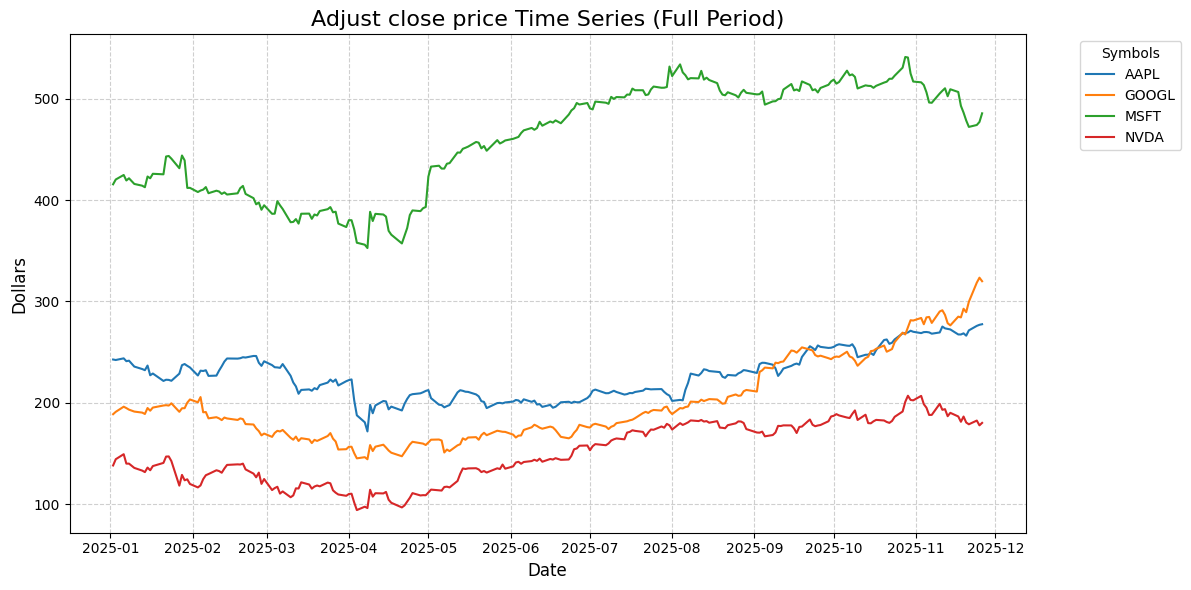


📊 Simple Returns (Sample):


Ticker,AAPL,GOOGL,MSFT,NVDA
Date,,,,
2025-01-03,-0.050237,0.311460,0.284892,1.113441
2025-01-06,0.168478,0.662185,0.265737,0.858308
2025-01-07,-0.284695,-0.175243,-0.320204,-1.554240
2025-01-08,0.050576,-0.196940,0.129623,-0.005350
2025-01-10,-0.602595,-0.246201,-0.330341,-0.749408
...,...,...,...,...
2025-11-20,-0.215036,-0.286874,-0.400033,-0.788120
2025-11-21,0.492018,0.881844,-0.329724,-0.243578
2025-11-24,0.407936,1.578454,0.099551,0.512913


,The daily value of the portfolio
Date,
2025-01-03,2033.191123
2025-01-06,2072.934054
2025-01-07,2024.543845
2025-01-08,2024.0966
2025-01-10,1985.060972
...,...
2025-11-20,2584.891033
2025-11-21,2605.58464
2025-11-24,2673.300005


Ticker,AAPL,GOOGL,MSFT,NVDA
Ticker,,,,
AAPL,4.553659,2.281079,1.674232,3.073738
GOOGL,2.281079,4.406319,1.476164,3.302786
MSFT,1.674232,1.476164,2.461260,3.325662
NVDA,3.073738,3.302786,3.325662,10.432007


np.float64(1.8048643864835672)

,Sharpe Ratio
Ticker,
AAPL,0.001215
GOOGL,0.005036
MSFT,0.001200
NVDA,0.003148


[-0.37105948  1.50014853  0.17179926 -0.04748426]


In [9]:
# ==============================================================================
# 📚 1. Standard Library Imports
# ==============================================================================
from datetime import date, datetime
import sys
from typing import List, Set, Tuple

# ==============================================================================
# 📚 2. Third-Party Library Imports
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display

# ==============================================================================
# 📚 3. Helper Module Imports
# ==============================================================================
# Assuming these exist in your local environment
from input_number_symbols import get_integer_input, get_valid_symbols
from date_checker import get_min_valid_date, get_valid_date_input
from interval import set_interval



from scipy.optimize import minimize
# ==============================================================================
# ⚙️ 4. Global Constants (Risk-Free Rate)
# ==============================================================================
# Using 4.25% Annual Risk-Free Rate as a default proxy
RISK_FREE_RATE_ANNUAL = 4.25


# ==============================================================================
# ⬇️ 5. Optimized Rolling Metric Function
# ==============================================================================


def calculate_rolling_metrics_optimized(
    df: pd.DataFrame, time_frame: int, time_step: int, coefficient: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calculates rolling Mean, Volatility, and Sharpe Ratio.
    """
    if time_frame > len(df):
        raise ValueError("Time frame is larger than the total number of data points.")

    # Calculate simple returns
    df_simple_returns = df.pct_change() * 100
    df_simple_returns = df_simple_returns.dropna()

    # 1. Calculate Rolling Mean & Volatility
    df_rolling_mean = df_simple_returns.rolling(window=time_frame).mean()
    df_rolling_vol = df_simple_returns.rolling(window=time_frame).std()

    # 2. Calculate Rolling Sharpe Ratio
    # Formula: (Rolling Mean - Daily Risk Free) / Rolling Volatility
    Rf_per_period = (1 + RISK_FREE_RATE_ANNUAL) ** (1 / coefficient) - 1
    df_rolling_sharpe = (
        (df_rolling_mean - Rf_per_period) / df_rolling_vol * np.sqrt(coefficient)
    )

    # 3. Step the results to reduce data density for plotting
    start_index = time_frame - 1
    df_mean_stepped = df_rolling_mean.iloc[start_index::time_step].dropna(how="all")
    df_vol_stepped = df_rolling_vol.iloc[start_index::time_step].dropna(how="all")
    df_sharpe_stepped = df_rolling_sharpe.iloc[start_index::time_step].dropna(how="all")

    return (df_mean_stepped, df_vol_stepped, df_sharpe_stepped)


# ==============================================================================
# 📈 6. Visualization Function
# ==============================================================================


def plot_metrics(
    df: pd.DataFrame,
    title: str,
    is_rolling: bool,
    kind: str = "line",
    time_frame: int = None,
    time_step: int = None,
    value_label: str = None,
):
    """Generates and displays a plot (Line or Bar) for the given DataFrame."""
    try:
        # Create figure
        plt.figure(figsize=(12, 6))

        full_title = title
        x_label = "Date"

        if is_rolling:
            full_title += f"\n(Window Size: {time_frame}, Step: {time_step})"
            x_label = "End Date of Rolling Window"

        # Plot Logic
        if kind == "bar":
            # Bar chart for scalar comparisons (Full Period)
            # We use a distinct color (e.g., orange) for volatility if indicated in title, otherwise default
            if "Volatility" in title:
                color = "red"
            elif "Sharpe" in title:
                color = "blue"

            df.plot(
                kind="bar", figsize=(12, 6), color=color, alpha=0.8, edgecolor="black"
            )
            plt.axhline(0, color="black", linewidth=0.8)  # Add zero line
            x_label = "Symbols"
            plt.xticks(rotation=0)
        else:
            # Line chart for time series (Rolling)
            plt.plot(df)
            x_label = "Date"
        if value_label:
            y_label = value_label
        else:
            y_label = "Value"

        plt.title(full_title, fontsize=16)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label, fontsize=12)

        if kind == "line":
            plt.legend(
                df.columns, title="Symbols", bbox_to_anchor=(1.05, 1), loc="upper left"
            )
        else:
            # For bar charts, the legend is often redundant if the x-axis labels are clear,
            # but we keep it for consistency or disable if single metric.
            pass

        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not generate plot for '{title}'. Error: {e}")


# ==============================================================================
# 🏁 7. Main Execution Block
# ==============================================================================


def execute_analysis():
    # --- Input Collection ---
    N_stocks = get_integer_input("Please enter the number of stocks: ")
    Set_stocks: Set[str] = get_valid_symbols(N_stocks)

    if not Set_stocks:
        print("Execution aborted due to symbol entry error.")
        sys.exit()

    List_stocks: List[str] = list(Set_stocks)
    print(f"\n**Selected Stocks:** {List_stocks}\n")
    option = str(print(f"You are in Poortfolio mode, you should enter a weight vector. if you don't enter a vector we consider the weith of all symbols equal to 1/Number of stocks!"))
    total_amount=input(f"enter the totla amount that you want invest on this portfolio:(it is default 1000 ueros)")
    try:
        total_amount = float(total_amount)
    except:
        total_amount = 1000
    if option.upper() == "Y":
        weight = np.zeros(N_stocks)
        for i in range(N_stocks):
            counter = 0
            while counter < 3:
                weight[i] = input(f"enter the weight of the {List_stocks[i]}:")
                try:
                    weight[i] = float(weight[i])
                    break
                except:
                    if counter != 2:
                        print(f"{weight[i]} is not an axceptable value!")
                        counter += 1
                    else:
                        print("Check your suitable weight vectors then try again!")
                        sys.exit()
    else:
        weight = np.array([1/N_stocks] * N_stocks) 
    sum_weight = sum(weight)
    normal_w = weight/sum_weight*100
    print(f"The normalize weight vector considered is {normal_w}")
    min_common_date = get_min_valid_date(Set_stocks)
    today_date = date.today()
    S_date = get_valid_date_input(
        f"Enter Start Date (YYYY-MM-DD, min: {min_common_date}): ",
        min_date=min_common_date,
        max_date=today_date,
    )
    S_date_dt = datetime.strptime(S_date, "%Y-%m-%d").date()
    E_date = get_valid_date_input(
        f"Enter End Date (YYYY-MM-DD, min: {S_date}): ",
        min_date=S_date_dt,
        max_date=today_date,
    )
    interval, coefficient = set_interval(S_date, E_date)
    print(f"\n**Data Range:** {S_date} to {E_date}, Interval: {interval}")

    # --- Data Download & Pre-processing ---
    print("\n⬇️ Downloading data from Yahoo Finance...")
    try:
        data = yf.download(
            List_stocks, start=S_date, end=E_date, interval=interval, auto_adjust=False
        )
        if data.empty:
            raise ValueError("No data returned.")
    except Exception as e:
        print(f"🛑 Error during data download: {e}")
        sys.exit()

    # Extract Adjusted Close
    DF_Adj_Close: pd.DataFrame = data["Adj Close"].copy()
    DF_Adj_Close.dropna(inplace=True)
    display(DF_Adj_Close)
    plot_metrics(
        DF_Adj_Close,
        "Adjust close price Time Series (Full Period)",
        is_rolling=False,
        kind="line",
        value_label="Dollars",
    )

    if DF_Adj_Close.empty or len(DF_Adj_Close) < 2:
        print("🛑 Insufficient valid data. Aborting.")
        sys.exit()

    # 1. Calculate Simple Returns
    DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
    DF_simple_return = DF_simple_return.dropna()
    dF_simple_return = DF_simple_return.mul(normal_w)/100
    print("\n📊 Simple Returns (Sample):")
    display(dF_simple_return)
    # 2. Portfolio value in each day
    DF_Prt_value_daily = pd.DataFrame(index=dF_simple_return.index, columns=["The daily value of the portfolio"])
    for i in dF_simple_return.index:
        DF_Prt_value_daily.loc[i] =(100+dF_simple_return.loc[i].sum())/100*total_amount
        total_amount = DF_Prt_value_daily.loc[i]
    display(DF_Prt_value_daily)
    df_cov = DF_simple_return.cov()
    display(df_cov)
    cov_matrix = df_cov.to_numpy()
    volatality_indicator = np.sqrt(np.dot(normal_w.T/100, np.dot(cov_matrix, normal_w/100)))
    display(volatality_indicator)
    Rf_per_period = (1 + RISK_FREE_RATE_ANNUAL) ** (1 / coefficient) - 1
    df_sharpe_full = (dF_simple_return.mean() - Rf_per_period) / np.sqrt(np.dot(normal_w.T, np.dot(cov_matrix, normal_w))) * np.sqrt(coefficient)
    df_sharpe_full = df_sharpe_full.to_frame('Sharpe Ratio')
    display(df_sharpe_full)


    # Assuming necessary Markowitz setup functions are defined...

    # =========================================================
    # 1. ACTUAL OBJECTIVE (The function you want to maximize)
    # =========================================================
    def calculate_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        """Calculates the annualized Sharpe Ratio for a set of weights."""
        # (Your Markowitz calculation logic goes here...)
        # ...
        # return sharpe_ratio
        # ----------------------------------------------------
        # DUMMY implementation for concept:
        annual_return = np.sum(mean_returns * weights) * 252
        annual_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
        sharpe_ratio = (annual_return - risk_free_rate) / annual_volatility
        return sharpe_ratio

    # =========================================================
    # 2. MINIMIZATION PROXY (The function you pass to SciPy)
    # =========================================================
    def negative_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
        """
        Returns the NEGATIVE Sharpe Ratio. 
        Minimizing this function maximizes the actual Sharpe Ratio.
        """
        sharpe = calculate_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate)
        return -sharpe
        
    # =========================================================
    # 3. CALLING MINIMIZE
    # =========================================================

    # Initial guess for weights (e.g., equally weighted)
    
    Rf_per_period = (1 + RISK_FREE_RATE_ANNUAL) ** (1 / coefficient) - 1
    # Run minimization of the NEGATIVE Sharpe Ratio
    optimal_results = minimize(
        negative_sharpe_ratio, # <--- The key: minimizing the negative
        normal_w/100,
        args=(DF_simple_return.mean(), cov_matrix, Rf_per_period),
        method='SLSQP',
        # ... other constraints and bounds go here ...
    )

    # The optimal weights (maximizers) are in optimal_results.x
    optimal_weights = optimal_results.x
    print(optimal_weights)
    
if __name__ == "__main__":
    execute_analysis()


Please enter the symbols of stocks you want to consider.

**Selected Stocks:** ['MSFT', 'GOOGL', 'AAPL', 'NVDA']

You are in Portfolio mode, you should enter a weight vector.

**Entering Custom Weights** (Must be non-negative)
The normalized weight vector considered is:
{'MSFT': np.float64(0.2), 'GOOGL': np.float64(0.2), 'AAPL': np.float64(0.1), 'NVDA': np.float64(0.5)}
Total normalized weight: 1.0000


🔍 Checking minimum valid history date for all selected stocks...
   -> Lowest valid date for MSFT is 1986-03-13
   -> Lowest valid date for GOOGL is 2004-08-19
   -> Lowest valid date for AAPL is 1980-12-12
   -> Lowest valid date for NVDA is 1999-01-22

✅ Given your symbol(s) list, the **minimum common valid start date** is: **2004-08-19**

📅 Given the selected dates, acceptable intervals are:
  - **1d**: 1 day (Full history)
  - **5d**: 5 day (Full history)
  - **1wk**: 1 week (Full history)
  - **1mo**: 1 month (Full history)
  - **3mo**: 3 month (Full history)

✅ Entered interval i

[*********************100%***********************]  4 of 4 completed


**Data Range:** 2024-01-01 to 2025-11-28, Interval: 1d

⬇️ Downloading data from Yahoo Finance...

📈 Adjusted Close Prices:


Ticker,AAPL,GOOGL,MSFT,NVDA
Date,,,,
2024-01-02,183.903244,137.223541,365.421600,48.143856
2024-01-03,182.526245,137.968430,365.155548,47.545158
2024-01-04,180.208130,135.455750,362.534637,47.973946
2024-01-05,179.484955,134.800278,362.347473,49.072392
2024-01-08,183.823975,137.888962,369.185516,52.226814


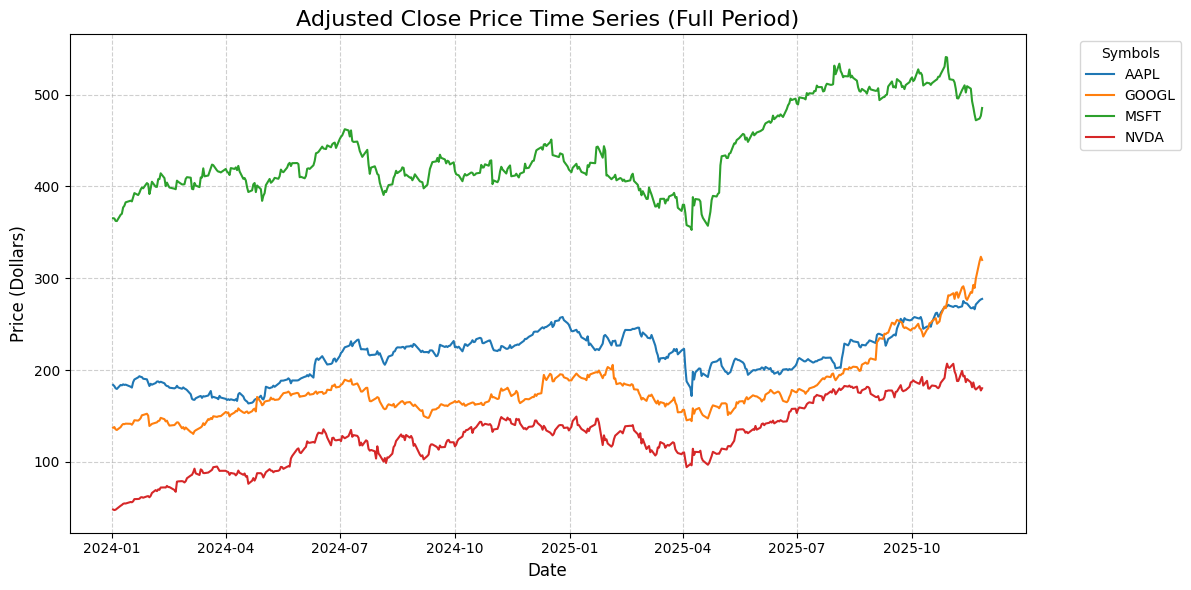


📊 Portfolio Simple Returns (Percentage, Sample):


Date
2024-01-03   -0.670247
2024-01-04   -0.239092
2024-01-05    0.962633
2024-01-08    4.344523
2024-01-09    1.136793
dtype: float64


💰 Daily Portfolio Value:


,The daily value of the portfolio
Date,
2024-01-03,1986.59505
2024-01-04,1981.845255
2024-01-05,2000.923153
2024-01-08,2087.853719
2024-01-09,2111.588295
...,...
2025-11-20,5286.479268
2025-11-21,5311.856729
2025-11-24,5452.873752


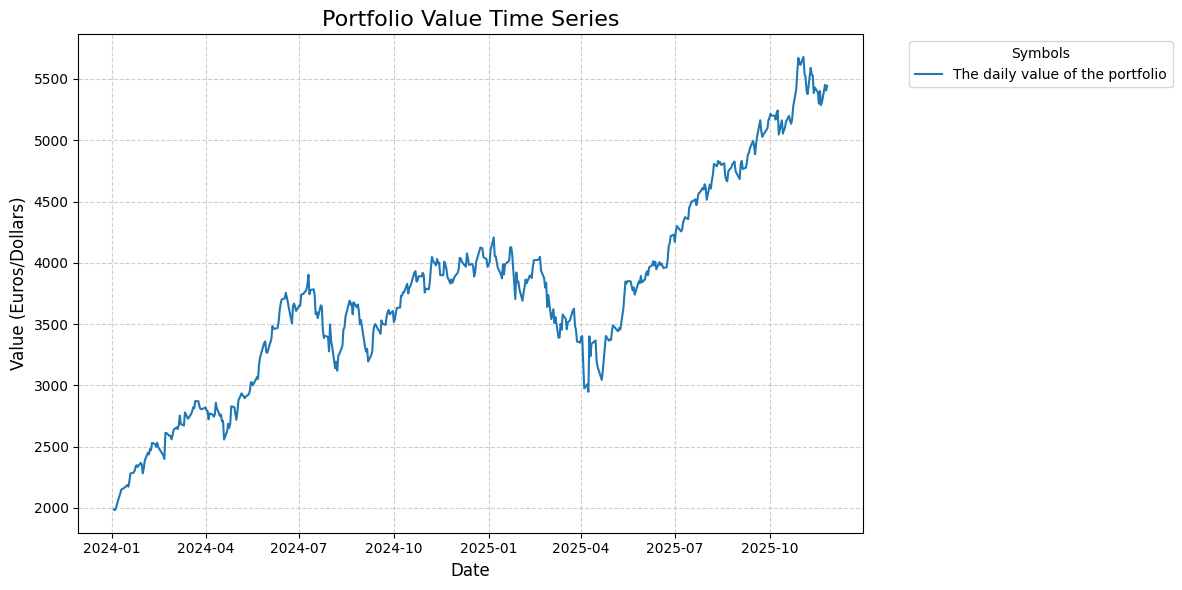


🔬 Returns Covariance Matrix (Percentage):


Ticker,AAPL,GOOGL,MSFT,NVDA
Ticker,,,,
AAPL,3.209566,1.546315,1.231501,2.063711
GOOGL,1.546315,3.721292,1.363717,2.513406
MSFT,1.231501,1.363717,1.990011,2.562865
NVDA,2.063711,2.513406,2.562865,10.691932



✨ Annualized Portfolio Volatility (Percentage): 33.1824%

⭐ Full Period Portfolio Annualized Sharpe Ratio:


,Sharpe Ratio
Portfolio,1.628935


<Figure size 1200x600 with 0 Axes>

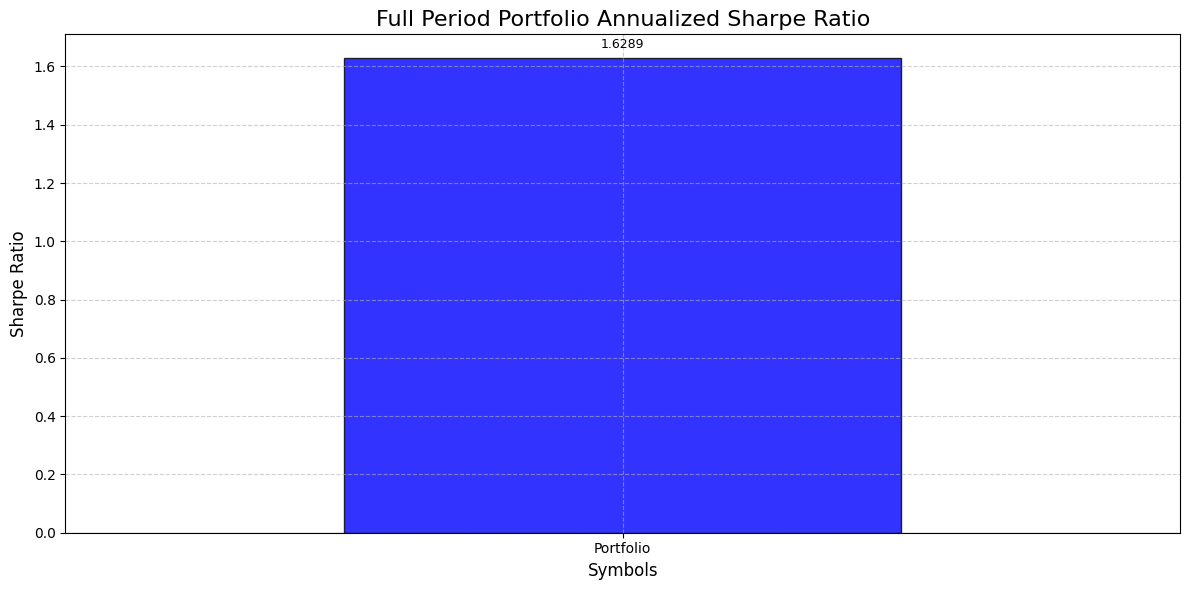


⚙️ Starting Markowitz Optimization (Maximize Sharpe Ratio)...

✅ Optimization Successful!
Optimal Annualized Sharpe Ratio: 1.7890

Optimal Weights (Decimal):
  MSFT: 0.0000 (0.00%)
  GOOGL: 0.6116 (61.16%)
  AAPL: 0.0000 (0.00%)
  NVDA: 0.3884 (38.84%)

Optimal Annualized Return: 62.4434%
Optimal Annualized Volatility: 32.5289%


In [10]:
# ==============================================================================
# 📚 1. Standard Library Imports
# ==============================================================================
from datetime import date, datetime
import sys
from typing import List, Set, Tuple

# ==============================================================================
# 📚 2. Third-Party Library Imports
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from IPython.display import display

# ==============================================================================
# 📚 3. Helper Module Imports
# ==============================================================================
# Assuming these exist in your local environment
from input_number_symbols import get_integer_input, get_valid_symbols
from date_checker import get_min_valid_date, get_valid_date_input
from interval import set_interval
from scipy.optimize import minimize # Already imported, just for clarity

# ==============================================================================
# ⚙️ 4. Global Constants (Risk-Free Rate)
# ==============================================================================
# Using 4.25% Annual Risk-Free Rate as a default proxy (as a percentage, e.g., 4.25)
RISK_FREE_RATE_ANNUAL = 4.25 / 100.0  # Converted to decimal (0.0425)

# ==============================================================================
# ⬇️ 5. Optimized Rolling Metric Function
# ==============================================================================

def calculate_rolling_metrics_optimized(
    df: pd.DataFrame, time_frame: int, time_step: int, coefficient: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """
    Calculates rolling Mean, Volatility, and Sharpe Ratio.
    The coefficient is the annualization factor (e.g., 252 for daily, 12 for monthly).
    """
    if time_frame > len(df):
        raise ValueError("Time frame is larger than the total number of data points.")

    # Calculate simple returns (returns are still in percentage for consistency with original code)
    df_simple_returns = df.pct_change() * 100 
    df_simple_returns = df_simple_returns.dropna()

    # 1. Calculate Rolling Mean & Volatility (Mean and Vol are in percentage)
    df_rolling_mean = df_simple_returns.rolling(window=time_frame).mean()
    df_rolling_vol = df_simple_returns.rolling(window=time_frame).std()

    # 2. Calculate Rolling Sharpe Ratio
    # Formula: (Rolling Mean - Daily Risk Free) / Rolling Volatility * Annualization Factor
    
    # Calculate daily/period risk-free rate (as a percentage)
    # R_daily = (1 + R_annual)^(1/coefficient) - 1. We multiply by 100 since returns are in percentage.
    Rf_per_period = ((1 + RISK_FREE_RATE_ANNUAL) ** (1 / coefficient) - 1) * 100
    
    # Sharpe Ratio: ((Mean Return - R_f) / Volatility) * sqrt(coefficient)
    # Returns/R_f/Vol are in percentage. The units cancel out.
    df_rolling_sharpe = (
        (df_rolling_mean - Rf_per_period) / df_rolling_vol * np.sqrt(coefficient)
    )

    # 3. Step the results to reduce data density for plotting
    start_index = time_frame - 1
    df_mean_stepped = df_rolling_mean.iloc[start_index::time_step].dropna(how="all")
    df_vol_stepped = df_rolling_vol.iloc[start_index::time_step].dropna(how="all")
    df_sharpe_stepped = df_rolling_sharpe.iloc[start_index::time_step].dropna(how="all")

    return (df_mean_stepped, df_vol_stepped, df_sharpe_stepped)


# ==============================================================================
# 📈 6. Visualization Function
# ==============================================================================

def plot_metrics(
    df: pd.DataFrame,
    title: str,
    is_rolling: bool,
    kind: str = "line",
    time_frame: int = None,
    time_step: int = None,
    value_label: str = None,
):
    """Generates and displays a plot (Line or Bar) for the given DataFrame."""
    try:
        # Create figure
        plt.figure(figsize=(12, 6))

        full_title = title
        x_label = "Date"
        color = None # Initialize color for plotting

        if is_rolling:
            full_title += f"\n(Window Size: {time_frame}, Step: {time_step})"
            x_label = "End Date of Rolling Window"

        # Plot Logic
        if kind == "bar":
            # Bar chart for scalar comparisons (Full Period)
            if "Volatility" in title:
                color = "red"
            elif "Sharpe" in title:
                color = "blue"
            elif "Mean" in title:
                color = "green"

            # Create axes object for better control
            ax = df.plot(
                kind="bar", figsize=(12, 6), color=color, alpha=0.8, edgecolor="black", legend=False
            )
            
            plt.axhline(0, color="black", linewidth=0.8)  # Add zero line
            x_label = "Symbols"
            plt.xticks(rotation=0)
            
            # Add value labels on top of bars
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')
        else:
            # Line chart for time series (Rolling)
            plt.plot(df)
            x_label = "Date"
            
        if value_label:
            y_label = value_label
        else:
            y_label = "Value"

        plt.title(full_title, fontsize=16)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label, fontsize=12)

        if kind == "line":
            plt.legend(
                df.columns, title="Symbols", bbox_to_anchor=(1.05, 1), loc="upper left"
            )
        
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        # Print the exception details for better debugging
        print(f"⚠️ Could not generate plot for '{title}'. Error: {e}", file=sys.stderr)


# ==============================================================================
# 🏁 7. Main Execution Block
# ==============================================================================

def execute_analysis():
    # --- Input Collection ---
    N_stocks = get_integer_input("Please enter the number of stocks: ")
    Set_stocks: Set[str] = get_valid_symbols(N_stocks)

    if not Set_stocks:
        print("Execution aborted due to symbol entry error.")
        sys.exit()

    List_stocks: List[str] = list(Set_stocks)
    print(f"\n**Selected Stocks:** {List_stocks}\n")
    
    # Weight Input Handling
    # Use input() for option, then strip/upper for reliable comparison
    print("You are in Portfolio mode, you should enter a weight vector.")
    option = input("Do you want to enter a custom weight vector? (Y/N, default is N for equal weight): ").strip().upper()
    
    total_amount_input = input(f"Enter the total amount that you want to invest in this portfolio (default: 1000 ueros): ")
    try:
        total_amount = float(total_amount_input)
    except ValueError:
        total_amount = 1000.0
        print(f"Invalid amount entered. Defaulting to {total_amount:.2f} ueros.")

    weight = np.zeros(N_stocks)
    if option == "Y":
        print("\n**Entering Custom Weights** (Must be non-negative)")
        for i in range(N_stocks):
            counter = 0
            while counter < 3:
                weight_input = input(f"Enter the weight of the {List_stocks[i]} (e.g., 0.1 for 10%): ")
                try:
                    w = float(weight_input)
                    if w < 0:
                         print("Weight must be non-negative.")
                         counter += 1
                         continue
                    weight[i] = w
                    break
                except ValueError:
                    if counter != 2:
                        print(f"'{weight_input}' is not an acceptable value! Try again.")
                        counter += 1
                    else:
                        print("Check your suitable weight vectors then try again!")
                        sys.exit()
            if counter == 3:
                 sys.exit()
    else:
        # Equal weights
        weight = np.array([1.0/N_stocks] * N_stocks) 
        print("\n**Using Equal Weights.**")

    # Normalize weights to sum to 1.0 (for portfolio calculations)
    sum_weight = np.sum(weight)
    if sum_weight == 0:
        print("🛑 Total weight is zero. Aborting.")
        sys.exit()
        
    normal_w = weight / sum_weight
    print(f"The normalized weight vector considered is:\n{dict(zip(List_stocks, normal_w))}")
    print(f"Total normalized weight: {normal_w.sum():.4f}\n")

    # Date Collection
    min_common_date = get_min_valid_date(Set_stocks)
    today_date = date.today()
    S_date = get_valid_date_input(
        f"Enter Start Date (YYYY-MM-DD, min: {min_common_date}): ",
        min_date=min_common_date,
        max_date=today_date,
    )
    S_date_dt = datetime.strptime(S_date, "%Y-%m-%d").date()
    E_date = get_valid_date_input(
        f"Enter End Date (YYYY-MM-DD, min: {S_date}): ",
        min_date=S_date_dt,
        max_date=today_date,
    )
    interval, coefficient = set_interval(S_date, E_date)
    print(f"\n**Data Range:** {S_date} to {E_date}, Interval: {interval}")

    # --- Data Download & Pre-processing ---
    print("\n⬇️ Downloading data from Yahoo Finance...")
    try:
        data = yf.download(
            List_stocks, start=S_date, end=E_date, interval=interval, auto_adjust=False
        )
        if data.empty:
            raise ValueError("No data returned.")
    except Exception as e:
        print(f"🛑 Error during data download: {e}", file=sys.stderr)
        sys.exit()

    # Extract Adjusted Close
    DF_Adj_Close: pd.DataFrame = data["Adj Close"].copy()
    DF_Adj_Close.dropna(inplace=True)
    
    print("\n📈 Adjusted Close Prices:")
    display(DF_Adj_Close.head())
    
    plot_metrics(
        DF_Adj_Close,
        "Adjusted Close Price Time Series (Full Period)",
        is_rolling=False,
        kind="line",
        value_label="Price (Dollars)",
    )

    if DF_Adj_Close.empty or len(DF_Adj_Close) < 2:
        print("🛑 Insufficient valid data. Aborting.")
        sys.exit()

    # 1. Calculate Simple Returns
    # Returns in percentage (as per original code: * 100)
    DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
    DF_simple_return = DF_simple_return.dropna()
    
    # Portfolio daily return (weighted sum of individual returns)
    # The returns are in percentage, so (normal_w * DF_simple_return.T) will be correct.
    # Result is a Series of daily portfolio returns (in percentage)
    portfolio_daily_returns_perc: pd.Series = DF_simple_return.dot(normal_w)
    print("\n📊 Portfolio Simple Returns (Percentage, Sample):")
    display(portfolio_daily_returns_perc.head())
    
    # 2. Portfolio value in each day
    DF_Prt_value_daily = pd.DataFrame(index=portfolio_daily_returns_perc.index, 
                                      columns=["The daily value of the portfolio"])
    
    current_portfolio_value = total_amount
    for i in portfolio_daily_returns_perc.index:
        # V_t = V_{t-1} * (1 + R_t/100)
        current_portfolio_value = current_portfolio_value * (1 + portfolio_daily_returns_perc.loc[i] / 100.0)
        DF_Prt_value_daily.loc[i] = current_portfolio_value
        
    print("\n💰 Daily Portfolio Value:")
    display(DF_Prt_value_daily)
    
    plot_metrics(
        DF_Prt_value_daily,
        "Portfolio Value Time Series",
        is_rolling=False,
        kind="line",
        value_label="Value (Euros/Dollars)",
    )

    # 3. Covariance Matrix & Portfolio Metrics
    df_cov = DF_simple_return.cov() # Covariance matrix of returns (in percentage)
    print("\n🔬 Returns Covariance Matrix (Percentage):")
    display(df_cov)
    cov_matrix = df_cov.to_numpy() # Covariance matrix (in percentage^2)

    # Portfolio Volatility (Annualized)
    # Volatility formula: sqrt(w^T * Cov * w) * sqrt(coefficient)
    # Since Cov is in percentage^2, and w is not normalized to 100, we need to divide Cov by 100^2
    # The normal_w vector sums to 1.0 (decimal weights)
    
    # Convert Covariance Matrix from percentage^2 to decimal^2 (divide by 100*100 = 10000)
    cov_matrix_decimal = cov_matrix / 10000.0
    
    # Annualized Volatility (decimal): sqrt(w^T * Cov_decimal * w) * sqrt(coefficient)
    volatility_annual_decimal = np.sqrt(np.dot(normal_w.T, np.dot(cov_matrix_decimal, normal_w))) * np.sqrt(coefficient)
    volatility_annual_perc = volatility_annual_decimal * 100.0
    
    print(f"\n✨ Annualized Portfolio Volatility (Percentage): {volatility_annual_perc:.4f}%")

    # Annualized Portfolio Return (decimal): sum(w * mean_returns_decimal) * coefficient
    mean_returns_decimal = DF_simple_return.mean() / 100.0 # Convert mean returns from percentage to decimal
    portfolio_return_annual_decimal = np.sum(mean_returns_decimal * normal_w) * coefficient
    
    # Sharpe Ratio (Annualized)
    # Sharpe = (R_p - R_f) / Volatility
    # All inputs must be in decimal form
    
    sharpe_ratio_full = (portfolio_return_annual_decimal - RISK_FREE_RATE_ANNUAL) / volatility_annual_decimal

    # Create a DataFrame for the single Sharpe Ratio result
    df_sharpe_full = pd.DataFrame(
        {'Portfolio': sharpe_ratio_full}, 
        index=['Sharpe Ratio']
    ).T
    print("\n⭐ Full Period Portfolio Annualized Sharpe Ratio:")
    display(df_sharpe_full)
    
    plot_metrics(
        df_sharpe_full,
        "Full Period Portfolio Annualized Sharpe Ratio",
        is_rolling=False,
        kind="bar",
        value_label="Sharpe Ratio",
    )


    # =========================================================
    # 📈 Markowitz Optimization
    # =========================================================

    # 1. ACTUAL OBJECTIVE (The function you want to maximize)
    def calculate_sharpe_ratio(weights, mean_returns_decimal, cov_matrix_decimal, risk_free_rate_annual, coefficient):
        """Calculates the annualized Sharpe Ratio for a set of weights."""
        
        # Annualized Portfolio Return (decimal): sum(w * R_mean_decimal) * coefficient
        annual_return = np.sum(mean_returns_decimal * weights) * coefficient
        
        # Annualized Portfolio Volatility (decimal): sqrt(w^T * Cov_decimal * w) * sqrt(coefficient)
        annual_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_decimal, weights))) * np.sqrt(coefficient)
        
        # Guard against zero volatility
        if annual_volatility == 0:
            return 0.0
            
        sharpe_ratio = (annual_return - risk_free_rate_annual) / annual_volatility
        return sharpe_ratio

    # 2. MINIMIZATION PROXY (The function you pass to SciPy)
    def negative_sharpe_ratio(weights, mean_returns_decimal, cov_matrix_decimal, risk_free_rate_annual, coefficient):
        """
        Returns the NEGATIVE Sharpe Ratio. 
        Minimizing this function maximizes the actual Sharpe Ratio.
        """
        # Constraints in SciPy's minimize need to be functions that return zero at the boundary.
        # We need to enforce a sum of 1.0 for the weights.
        
        # Ensure sum of weights is 1 (equality constraint)
        if not np.isclose(np.sum(weights), 1.0):
             # This check is more for robustness; the constraint function below handles it better.
             pass 
             
        sharpe = calculate_sharpe_ratio(weights, mean_returns_decimal, cov_matrix_decimal, risk_free_rate_annual, coefficient)
        return -sharpe
        
    # 3. CALLING MINIMIZE
    
    # Optimization setup:
    # a. Bounds: Weights must be between 0 and 1 (or allow shorting if desired, e.g., -1 to 1)
    # b. Constraints: Sum of weights must equal 1 (100% investment)
    num_assets = len(List_stocks)
    
    # Bounds: (0, 1) for each stock (no short selling)
    bounds = tuple((0, 1) for _ in range(num_assets))
    
    # Constraints: sum of weights equals 1
    # 'type': 'eq' means equality constraint, func should return 0 when satisfied.
    constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
    
    # Initial guess: current normalized weights (which sum to 1)
    initial_weights = normal_w
    
    print("\n⚙️ Starting Markowitz Optimization (Maximize Sharpe Ratio)...")

    # Run minimization of the NEGATIVE Sharpe Ratio
    optimal_results = minimize(
        negative_sharpe_ratio, # <--- The key: minimizing the negative
        initial_weights, # Initial guess (decimal weights)
        args=(mean_returns_decimal, cov_matrix_decimal, RISK_FREE_RATE_ANNUAL, coefficient),
        method='SLSQP', # Sequential Least Squares Programming
        bounds=bounds,
        constraints=constraints
    )

    # The optimal weights (maximizers) are in optimal_results.x
    if optimal_results.success:
        optimal_weights = optimal_results.x
        optimal_sharpe = -optimal_results.fun
        
        print("\n✅ Optimization Successful!")
        print(f"Optimal Annualized Sharpe Ratio: {optimal_sharpe:.4f}")
        print("\nOptimal Weights (Decimal):")
        optimal_weights_dict = dict(zip(List_stocks, optimal_weights))
        for symbol, weight in optimal_weights_dict.items():
            print(f"  {symbol}: {weight:.4f} ({weight*100:.2f}%)")
        
        # Calculate optimal portfolio volatility and return for display
        optimal_return_annual = np.sum(mean_returns_decimal * optimal_weights) * coefficient
        optimal_volatility_annual = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix_decimal, optimal_weights))) * np.sqrt(coefficient)
        
        print(f"\nOptimal Annualized Return: {optimal_return_annual*100:.4f}%")
        print(f"Optimal Annualized Volatility: {optimal_volatility_annual*100:.4f}%")
        
    else:
        print(f"\n❌ Optimization Failed. Status: {optimal_results.message}")
        print(f"Current best weights: {optimal_results.x}")
    
if __name__ == "__main__":
    execute_analysis()

   🚀 FINANCIAL ANALYSIS TOOLKIT V1.0    

Please select your Analysis Mode:
[1] Individual Stock Analysis (Rolling Mean, Volatility, Sharpe)
[2] Portfolio Optimization (Weights, Covariance, Markowitz)

--- Data Configuration ---

🍪 Generating 5 random S&P 500 symbols...

**Selected Stocks:** ['VTR', 'LULU', 'DE', 'AMCR', 'JKHY']


🔍 Checking minimum valid history date for all selected stocks...
   -> Lowest valid date for VTR is 1997-05-05
   -> Lowest valid date for LULU is 2007-07-27
   -> Lowest valid date for DE is 1972-06-01
   -> Lowest valid date for AMCR is 2012-05-15
   -> Lowest valid date for JKHY is 1985-11-20

✅ Given your symbol(s) list, the **minimum common valid start date** is: **2012-05-15**

📅 Given the selected dates, acceptable intervals are:
  - **1d**: 1 day (Full history)
  - **5d**: 5 day (Full history)
  - **1wk**: 1 week (Full history)
  - **1mo**: 1 month (Full history)
  - **3mo**: 3 month (Full history)

✅ Entered interval is **1d** (1 day (Full history)).

[*********************100%***********************]  5 of 5 completed


Ticker,AMCR,DE,JKHY,LULU,VTR
Date,,,,,
2024-01-02,9.032454,390.978516,160.949814,505.380005,47.836182
2024-01-03,8.893494,383.605804,159.747513,498.019989,46.965919
2024-01-04,8.930551,382.669556,162.914536,496.000000,46.597004
2024-01-05,9.023190,386.151093,162.963379,491.100006,46.048355
2024-01-08,9.088038,388.121063,165.876221,491.480011,46.076736


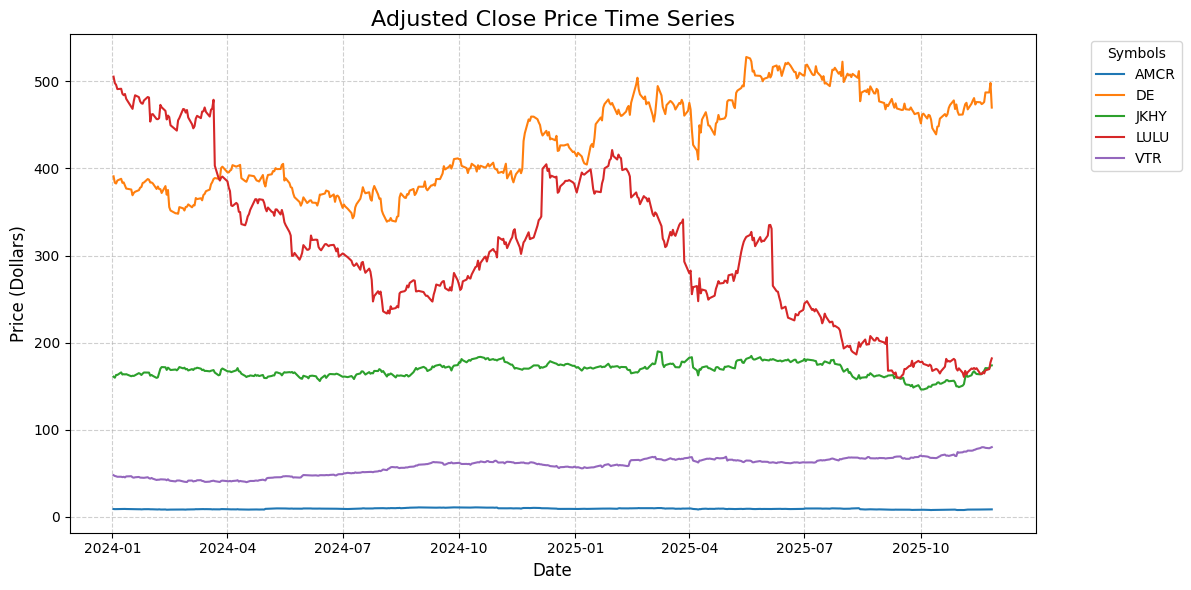


🟣 STARTING PORTFOLIO OPTIMIZATION

**Entering Custom Weights** (Must be non-negative)
Normalized weights: {'VTR': np.float64(0.15625), 'LULU': np.float64(0.21875), 'DE': np.float64(0.1875), 'AMCR': np.float64(0.28125), 'JKHY': np.float64(0.15625)}

💰 Daily Portfolio Value:


,The daily value of the portfolio
Date,
2024-01-03,1970.264061
2024-01-04,1973.153025
2024-01-05,1971.276586
2024-01-08,1982.915524
2024-01-09,1961.364618


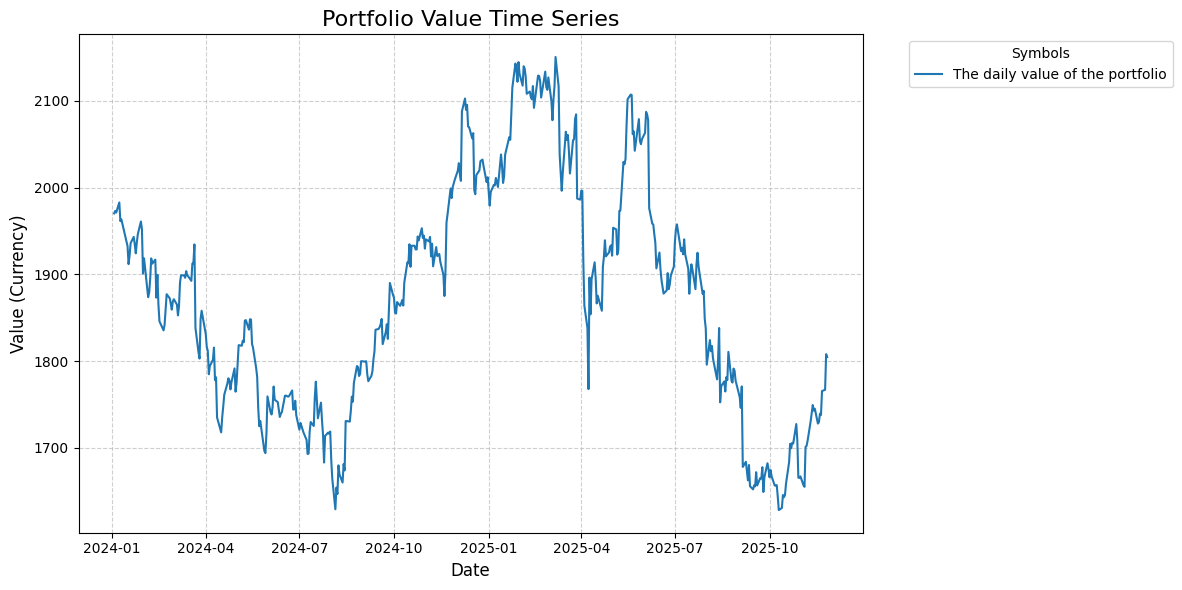


✨ Current Annualized Portfolio Volatility: 19.3675%

⭐ Full Period Portfolio Annualized Sharpe Ratio:


,Sharpe Ratio
Portfolio,-0.40213


<Figure size 1200x600 with 0 Axes>

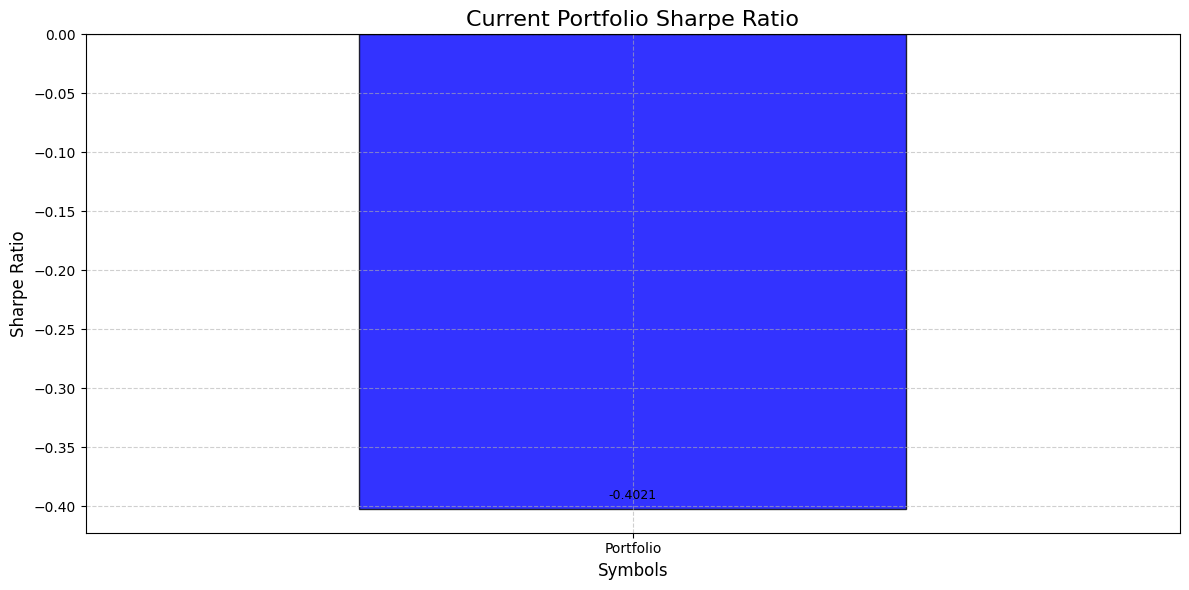


⚙️ Starting Markowitz Optimization (Maximize Sharpe Ratio)...

✅ Optimization Successful!
Optimal Annualized Sharpe Ratio: 1.1701

Optimal Weights (Decimal):
  VTR: 0.0000 (0.00%)
  LULU: 0.0889 (8.89%)
  DE: 0.0000 (0.00%)
  AMCR: 0.0000 (0.00%)
  JKHY: 0.9111 (91.11%)

Optimal Annualized Return: 28.0643%
Optimal Annualized Volatility: 20.3529%


In [3]:
# ==============================================================================
# 📚 1. Standard Library Imports
# ==============================================================================
from datetime import date, datetime
import sys
from typing import List, Set, Tuple

# ==============================================================================
# 📚 2. Third-Party Library Imports
# ==============================================================================
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from IPython.display import display

# ==============================================================================
# 📚 3. Helper Module Imports
# ==============================================================================
try:
    from input_number_symbols import get_integer_input, get_valid_symbols
    from date_checker import get_min_valid_date, get_valid_date_input
    from interval import set_interval
except ImportError as e:
    print(f"⚠️ Critical Import Error: {e}")
    print("Please ensure 'input_number_symbols.py', 'date_checker.py', and 'interval.py' are in the directory.")
    sys.exit()

# ==============================================================================
# ⚙️ 4. Global Constants (Risk-Free Rate)
# ==============================================================================
RISK_FREE_RATE_PERCENT = 4.25           # e.g., 4.25
RISK_FREE_RATE_DECIMAL = 4.25 / 100.0   # e.g., 0.0425


# ==============================================================================
# 🧮 5. Calculation Functions
# ==============================================================================

def calculate_rolling_metrics_optimized(
    df: pd.DataFrame, time_frame: int, time_step: int, coefficient: int
) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    """Calculates rolling Mean, Volatility, and Sharpe Ratio (Script 1 Logic)."""
    if time_frame > len(df):
        raise ValueError("Time frame is larger than the total number of data points.")

    df_simple_returns = df.pct_change() * 100
    df_simple_returns = df_simple_returns.dropna()

    df_rolling_mean = df_simple_returns.rolling(window=time_frame).mean()
    df_rolling_vol = df_simple_returns.rolling(window=time_frame).std()

    Rf_per_period = (1 + RISK_FREE_RATE_PERCENT/100) ** (1 / coefficient) - 1
    Rf_per_period_perc = Rf_per_period * 100
    
    df_rolling_sharpe = (
        (df_rolling_mean - Rf_per_period_perc) / df_rolling_vol * np.sqrt(coefficient)
    )

    start_index = time_frame - 1
    df_mean_stepped = df_rolling_mean.iloc[start_index::time_step].dropna(how="all")
    df_vol_stepped = df_rolling_vol.iloc[start_index::time_step].dropna(how="all")
    df_sharpe_stepped = df_rolling_sharpe.iloc[start_index::time_step].dropna(how="all")

    return (df_mean_stepped, df_vol_stepped, df_sharpe_stepped)


def calculate_sharpe_ratio(weights, mean_returns_decimal, cov_matrix_decimal, risk_free_rate_annual, coefficient):
    """Calculates the annualized Sharpe Ratio (Script 2 Logic)."""
    annual_return = np.sum(mean_returns_decimal * weights) * coefficient
    annual_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix_decimal, weights))) * np.sqrt(coefficient)
    
    if annual_volatility == 0:
        return 0.0
        
    sharpe_ratio = (annual_return - risk_free_rate_annual) / annual_volatility
    return sharpe_ratio


def negative_sharpe_ratio(weights, mean_returns_decimal, cov_matrix_decimal, risk_free_rate_annual, coefficient):
    """Objective function for minimization."""
    if not np.isclose(np.sum(weights), 1.0):
         pass 
    sharpe = calculate_sharpe_ratio(weights, mean_returns_decimal, cov_matrix_decimal, risk_free_rate_annual, coefficient)
    return -sharpe


# ==============================================================================
# 📈 6. Visualization Function
# ==============================================================================

def plot_metrics(
    df: pd.DataFrame,
    title: str,
    is_rolling: bool,
    kind: str = "line",
    time_frame: int = None,
    time_step: int = None,
    value_label: str = None,
):
    try:
        plt.figure(figsize=(12, 6))
        full_title = title
        x_label = "Date"
        color = None 

        if is_rolling:
            full_title += f"\n(Window Size: {time_frame}, Step: {time_step})"
            x_label = "End Date of Rolling Window"

        if kind == "bar":
            if "Volatility" in title: color = "red"
            elif "Sharpe" in title: color = "blue"
            elif "Mean" in title: color = "green"

            ax = df.plot(kind="bar", figsize=(12, 6), color=color, alpha=0.8, edgecolor="black", legend=False)
            plt.axhline(0, color="black", linewidth=0.8)
            x_label = "Symbols"
            plt.xticks(rotation=0)
            
            for p in ax.patches:
                ax.annotate(f"{p.get_height():.4f}", (p.get_x() + p.get_width() / 2., p.get_height()), 
                            ha='center', va='bottom', fontsize=9, color='black', xytext=(0, 5), textcoords='offset points')
        else:
            plt.plot(df)
            x_label = "Date"
            
        y_label = value_label if value_label else "Value"

        plt.title(full_title, fontsize=16)
        plt.xlabel(x_label, fontsize=12)
        plt.ylabel(y_label, fontsize=12)

        if kind == "line":
            plt.legend(df.columns, title="Symbols", bbox_to_anchor=(1.05, 1), loc="upper left")
        
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"⚠️ Could not generate plot for '{title}'. Error: {e}", file=sys.stderr)


# ==============================================================================
# 🏁 7. Main Execution Block
# ==============================================================================

def execute_analysis():
    print("=========================================")
    print("   🚀 FINANCIAL ANALYSIS TOOLKIT V1.0    ")
    print("=========================================\n")

    # ---------------------------------------------------------
    # PART A: SELECT MODE (Moved to the start)
    # ---------------------------------------------------------
    print("Please select your Analysis Mode:")
    print("[1] Individual Stock Analysis (Rolling Mean, Volatility, Sharpe)")
    print("[2] Portfolio Optimization (Weights, Covariance, Markowitz)")
    
    mode = input("Enter 1 or 2: ").strip()
    
    if mode not in ["1", "2"]:
        print("🛑 Invalid mode selection. Exiting.")
        sys.exit()

    # ---------------------------------------------------------
    # PART B: Input Collection & Data Download
    # ---------------------------------------------------------
    print("\n--- Data Configuration ---")
    N_stocks = get_integer_input("Please enter the number of stocks: ")
    
    # Validation hint for Portfolio Mode
    if mode == "2" and N_stocks < 2:
        print("⚠️ Note: Portfolio optimization typically requires 2 or more stocks.")
        
    Set_stocks: Set[str] = get_valid_symbols(N_stocks)

    if not Set_stocks:
        print("Execution aborted due to symbol entry error.")
        sys.exit()

    List_stocks: List[str] = list(Set_stocks)
    print(f"\n**Selected Stocks:** {List_stocks}\n")

    # Date Collection
    min_common_date = get_min_valid_date(Set_stocks)
    today_date = date.today()
    S_date = get_valid_date_input(
        f"Enter Start Date (YYYY-MM-DD, min: {min_common_date}): ",
        min_date=min_common_date,
        max_date=today_date,
    )
    S_date_dt = datetime.strptime(S_date, "%Y-%m-%d").date()
    E_date = get_valid_date_input(
        f"Enter End Date (YYYY-MM-DD, min: {S_date}): ",
        min_date=S_date_dt,
        max_date=today_date,
    )
    interval, coefficient = set_interval(S_date, E_date)
    print(f"\n**Data Range:** {S_date} to {E_date}, Interval: {interval}")

    # Data Download
    print("\n⬇️ Downloading data from Yahoo Finance...")
    try:
        data = yf.download(
            List_stocks, start=S_date, end=E_date, interval=interval, auto_adjust=False
        )
        if data.empty:
            raise ValueError("No data returned.")
    except Exception as e:
        print(f"🛑 Error during data download: {e}", file=sys.stderr)
        sys.exit()

    # Extract Adjusted Close
    DF_Adj_Close: pd.DataFrame = data["Adj Close"].copy()
    DF_Adj_Close.dropna(inplace=True)
    
    if DF_Adj_Close.empty or len(DF_Adj_Close) < 2:
        print("🛑 Insufficient valid data. Aborting.")
        sys.exit()

    # Initial Plot
    display(DF_Adj_Close.head())
    plot_metrics(
        DF_Adj_Close,
        "Adjusted Close Price Time Series",
        is_rolling=False,
        kind="line",
        value_label="Price (Dollars)",
    )

    # ---------------------------------------------------------
    # PART C: Execute Selected Mode Logic
    # ---------------------------------------------------------

    # ==============================================================================
    # MODE 1: Individual Stock Analysis
    # ==============================================================================
    if mode == "1":
        print("\n🔵 STARTING INDIVIDUAL STOCK ANALYSIS")
        
        DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
        DF_simple_return = DF_simple_return.dropna()
        
        print("\n📊 Simple Returns (Sample):")
        display(DF_simple_return.head())

        option = str(input("\nDo you want Full-Period results (Y) or Rolling Time Frame (N)? (Y/N): ")).strip().upper()

        if option == "Y":
            # Full Period
            df_mean_full = DF_simple_return.mean().to_frame("Mean Return")
            df_vol_full = DF_simple_return.std().to_frame("Volatility")

            Rf_per_period = (1 + RISK_FREE_RATE_PERCENT/100) ** (1 / coefficient) - 1
            Rf_per_period_perc = Rf_per_period * 100
            
            df_sharpe_full = (
                (df_mean_full["Mean Return"] - Rf_per_period_perc)
                / df_vol_full["Volatility"]
                * np.sqrt(coefficient)
            )
            df_sharpe_full = df_sharpe_full.to_frame("Sharpe Ratio")

            df_results = pd.concat([df_mean_full, df_vol_full, df_sharpe_full], axis=1)
            print("\n📊 Full Period Metrics:")
            display(df_results)

            plot_metrics(DF_simple_return, "Simple Return Time Series", False, "line")
            plot_metrics(df_vol_full, "Full Period Volatility Comparison", False, "bar")
            plot_metrics(df_sharpe_full, "Full Period Sharpe Ratio Comparison", False, "bar")

        else:
            # Rolling Period
            print(f"\nGiven your data has **{len(DF_Adj_Close)}** periods.")
            time_frame = get_integer_input("Enter time_frame (window size, e.g., 20): ")
            time_step = get_integer_input("Enter time_step (periods to step, e.g., 5): ")

            try:
                (df_mean_roll, df_vol_roll, df_sharpe_roll) = calculate_rolling_metrics_optimized(
                    DF_Adj_Close, time_frame, time_step, coefficient
                )
                print("\n💹 Generating plots for rolling metrics...")
                plot_metrics(df_mean_roll, "Rolling Simple Mean Return", True, "line", time_frame, time_step, "Percent per period")
                plot_metrics(df_vol_roll, "Rolling Volatility", True, "line", time_frame, time_step, "Percent per period")
                plot_metrics(df_sharpe_roll, "Rolling Sharpe Ratio", True, "line", time_frame, time_step)

            except ValueError as e:
                print(f"\n🛑 Error in rolling calculation: {e}")
                sys.exit()

    # ==============================================================================
    # MODE 2: Portfolio Analysis
    # ==============================================================================
    elif mode == "2":
        print("\n🟣 STARTING PORTFOLIO OPTIMIZATION")
        
        # 1. Weights
        option = input("Do you want to enter a custom weight vector? (Y/N, default is N for equal weight): ").strip().upper()
        
        total_amount_input = input(f"Enter the total amount to invest (default: 1000 euros): ")
        try:
            total_amount = float(total_amount_input)
        except ValueError:
            total_amount = 1000.0
            print(f"Invalid amount entered. Defaulting to {total_amount:.2f} euros.")

        weight = np.zeros(N_stocks)
        if option == "Y":
            print("\n**Entering Custom Weights** (Must be non-negative)")
            for i in range(N_stocks):
                while True:
                    weight_input = input(f"Enter the weight of {List_stocks[i]} (e.g., 0.1): ")
                    try:
                        w = float(weight_input)
                        if w < 0:
                            print("Weight must be non-negative.")
                            continue
                        weight[i] = w
                        break
                    except ValueError:
                        print("Invalid number. Try again.")
        else:
            weight = np.array([1.0/N_stocks] * N_stocks) 
            print("\n**Using Equal Weights.**")

        sum_weight = np.sum(weight)
        if sum_weight == 0:
            print("🛑 Total weight is zero. Aborting.")
            sys.exit()
        normal_w = weight / sum_weight
        print(f"Normalized weights: {dict(zip(List_stocks, normal_w))}")

        # 2. Portfolio Calculation
        DF_simple_return: pd.DataFrame = DF_Adj_Close.pct_change() * 100
        DF_simple_return = DF_simple_return.dropna()
        
        portfolio_daily_returns_perc: pd.Series = DF_simple_return.dot(normal_w)
        
        DF_Prt_value_daily = pd.DataFrame(index=portfolio_daily_returns_perc.index, 
                                          columns=["The daily value of the portfolio"])
        current_portfolio_value = total_amount
        for i in portfolio_daily_returns_perc.index:
            current_portfolio_value = current_portfolio_value * (1 + portfolio_daily_returns_perc.loc[i] / 100.0)
            DF_Prt_value_daily.loc[i] = current_portfolio_value
            
        print("\n💰 Daily Portfolio Value:")
        display(DF_Prt_value_daily.head())
        plot_metrics(DF_Prt_value_daily, "Portfolio Value Time Series", False, "line", value_label="Value (Currency)")

        # 3. Metrics
        df_cov = DF_simple_return.cov()
        cov_matrix = df_cov.to_numpy()
        cov_matrix_decimal = cov_matrix / 10000.0 # Convert from %^2 to decimal^2
        
        volatility_annual_decimal = np.sqrt(np.dot(normal_w.T, np.dot(cov_matrix_decimal, normal_w))) * np.sqrt(coefficient)
        volatility_annual_perc = volatility_annual_decimal * 100.0
        print(f"\n✨ Current Annualized Portfolio Volatility: {volatility_annual_perc:.4f}%")

        mean_returns_decimal = DF_simple_return.mean() / 100.0
        portfolio_return_annual_decimal = np.sum(mean_returns_decimal * normal_w) * coefficient
        
        sharpe_ratio_full = (portfolio_return_annual_decimal - RISK_FREE_RATE_DECIMAL) / volatility_annual_decimal

        df_sharpe_full = pd.DataFrame({'Portfolio': sharpe_ratio_full}, index=['Sharpe Ratio']).T
        print("\n⭐ Full Period Portfolio Annualized Sharpe Ratio:")
        display(df_sharpe_full)
        plot_metrics(df_sharpe_full, "Current Portfolio Sharpe Ratio", False, "bar", value_label="Sharpe Ratio")

        # 4. Optimization
        print("\n⚙️ Starting Markowitz Optimization (Maximize Sharpe Ratio)...")
        num_assets = len(List_stocks)
        bounds = tuple((0, 1) for _ in range(num_assets))
        constraints = ({'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1})
        initial_weights = normal_w

        optimal_results = minimize(
            negative_sharpe_ratio,
            initial_weights,
            args=(mean_returns_decimal, cov_matrix_decimal, RISK_FREE_RATE_DECIMAL, coefficient),
            method='SLSQP',
            bounds=bounds,
            constraints=constraints
        )

        if optimal_results.success:
            optimal_weights = optimal_results.x
            optimal_sharpe = -optimal_results.fun
            
            print("\n✅ Optimization Successful!")
            print(f"Optimal Annualized Sharpe Ratio: {optimal_sharpe:.4f}")
            print("\nOptimal Weights (Decimal):")
            optimal_weights_dict = dict(zip(List_stocks, optimal_weights))
            for symbol, weight in optimal_weights_dict.items():
                print(f"  {symbol}: {weight:.4f} ({weight*100:.2f}%)")
            
            optimal_return_annual = np.sum(mean_returns_decimal * optimal_weights) * coefficient
            optimal_volatility_annual = np.sqrt(np.dot(optimal_weights.T, np.dot(cov_matrix_decimal, optimal_weights))) * np.sqrt(coefficient)
            
            print(f"\nOptimal Annualized Return: {optimal_return_annual*100:.4f}%")
            print(f"Optimal Annualized Volatility: {optimal_volatility_annual*100:.4f}%")
        else:
            print(f"\n❌ Optimization Failed. Status: {optimal_results.message}")

if __name__ == "__main__":
    execute_analysis()